In [96]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Introduction

このノートブックでは、線形・非線形関数を用いた差異について調査する。

- パーセプトロン
- ADALINE
- ロジスティック回帰

の三種類のアルゴリズムについて比較を行い、それぞれの長所・短所を把握する

## 使用する関数

In [332]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    
    # (x1, x2) で座標を表す
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # スキャンする座標の組み合わせを作成する
    #   xx1 = (a1,b1,c1,d1,...)
    #   xx2 = (a2,b2,c2,d2,...)
    #   (xx1, xx2)^T = [(a1, a2),
    #                   (b1, b2),
    #                   ...]
    #
    Z = classifier.predict(np.array([
        xx1.ravel(),
        xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl,0],
                    X[y==cl,1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

# 線形分離可能なデータセット

まず初めに、線形分離なデータセット（直線で分離可能）を擬似的に作成する。クラスラベルは「-1, 1」であり、これは以下の実装で統一しておく必要がある（`np.where`で想定しているクラスと統一する必要があるため）。

In [193]:
data_seed = torch.randn((1000,2))
dataset =  np.append(
    np.append(np.full_like(np.zeros((1000,1)),-1), data_seed+1, axis=1),
    np.append(np.full_like(np.zeros((1000,1)),1), data_seed+10, axis=1),
    axis=0)

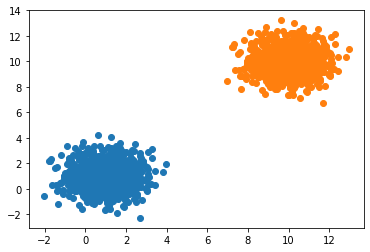

In [194]:
plt.plot(dataset[:1000][:,1],dataset[:1000][:,2],linewidth=0, marker="o")
plt.plot(dataset[1000:][:,1],dataset[1000:][:,2],linewidth=0, marker="o")

## パーセプトロン

データと重みベクトルの線型結合を計算し、二値分類を行うモデル。予測値は以下の式で定義される：

$$
\hat{y} = \phi(w^Tx)
$$

これを真の値と比較することで、重みの更新（分離平面の探索）を行なっていく。

パーセプトロンはデータ空間を超平面で分割できる場合に威力を発揮する。線形分離できない空間では収束しないことが数学的に証明されている（エポック数の最大値を決めて学習を打ち切るのが現実的）。

### 実験

In [304]:
class Perceptron:
    def __init__(self, eta, n_iter, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def net_input(self, X):
        # 総入力
        # データと重みベクトルの内積を取る（バイアス項には x_0 = 1 を掛ける）
        # 
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        # 閾値関数
        # 総入力（net input）が 0 以上かどうかで分類するステップ関数
        #
        return np.where(self.net_input(X)>= 0.0, 1, -1)
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.w_epoch = []
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            self.w_epoch.append(self.w_)
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
               
                self.w_[1:] += update * xi
                self.w_[0] += update
                    
                # update = 1 -> 誤差があったので、更新する
                # update = 0 -> 誤差はなく更新しない
                # そのため update の値を積算することで全更新回数がわかる
                #
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
        
        return self

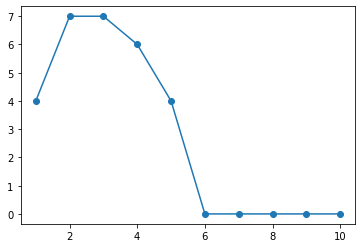

In [302]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(dataset[:,1:], dataset[:,0])
plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')

(743724,)


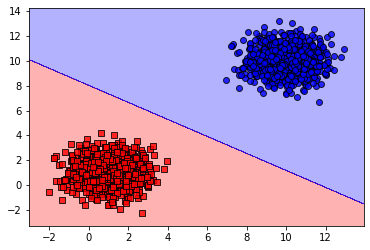

In [331]:
plot_decision_regions(dataset[:,1:], dataset[:,0], ppn)

線形分離可能なデータに対して、正しく線形分離の直線を描けていることがわかる。

## ADALINE

パーセプトロンが閾値関数を通して予測した結果を真の値と比較して学習を進めたと異なり、線形活性化関数が出力する連続値を比較する。　この連続値を用いることで、最適化（最小化）したい関数として損失関数を定義できる（パーセプトロンの場合はクラス数に相当する量子化された値しか用いていなかった）。

この損失関数を勾配降下法を用いて損失関数の最適値を探索する。ここでは二乗誤差を使用する。

$$
J(w) = \frac{1}{2} \sum (y-\phi(z))^2
$$

In [325]:
class AdalineGD:
    def __init__(self, eta, n_iter, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=0.0, 1, -1)
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []
        self.error_ = []
        
        for idx in range(self.n_iter):
            net_input = self.net_input(X)
            
            output = self.activation(net_input)
            
            errors = (y - output)
                
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        
        return

### 学習率の違いによる収束具合

- 学習率が大きいと極小値を飛び越えるため、誤差が発散してしまう
- 学習率を小さくできると発散しないが、収束までに大きなエポック数を要する

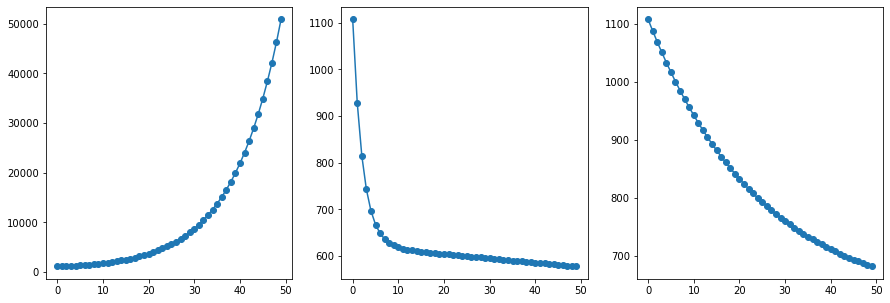

In [334]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ada_gd = AdalineGD(eta=1e-5, n_iter=50)
ada_gd.fit(dataset[:,1:], dataset[:,0])
ax[0].plot(ada_gd.cost_, marker='o')

ada_gd = AdalineGD(eta=1e-6, n_iter=50)
ada_gd.fit(dataset[:,1:], dataset[:,0])
ax[1].plot(ada_gd.cost_, marker='o')

ada_gd = AdalineGD(eta=1e-7, n_iter=50)
ada_gd.fit(dataset[:,1:], dataset[:,0])
ax[2].plot(ada_gd.cost_, marker='o')

### 標準化による収束度合いの改善

勾配降下法は特徴量のスケーリングの恩恵を受けるアルゴリズムの一つである。勾配降下法による学習をより素早く収束するのに効果がある。

In [335]:
dataset_std = np.copy(dataset)
dataset_std[:,1] = (dataset_std[:,1]-dataset_std[:,1].mean())/dataset_std[:,1].std()
dataset_std[:,2] = (dataset_std[:,2]-dataset_std[:,2].mean())/dataset_std[:,2].std()

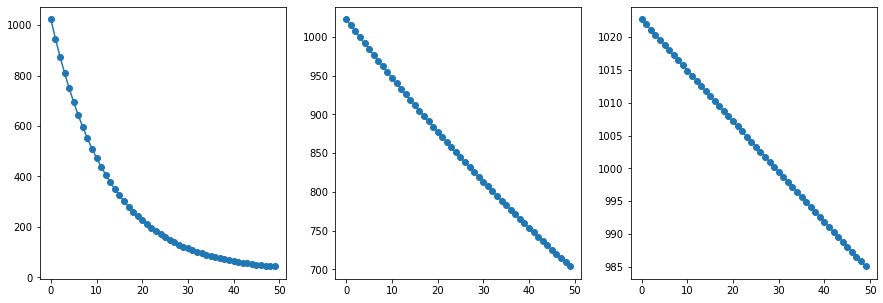

In [337]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ada_gd = AdalineGD(eta=1e-5, n_iter=50)
ada_gd.fit(dataset_std[:,1:], dataset_std[:,0])
ax[0].plot(ada_gd.cost_, marker='o')

ada_gd = AdalineGD(eta=1e-6, n_iter=50)
ada_gd.fit(dataset_std[:,1:], dataset_std[:,0])
ax[1].plot(ada_gd.cost_, marker='o')

ada_gd = AdalineGD(eta=1e-7, n_iter=50)
ada_gd.fit(dataset_std[:,1:], dataset_std[:,0])
ax[2].plot(ada_gd.cost_, marker='o')

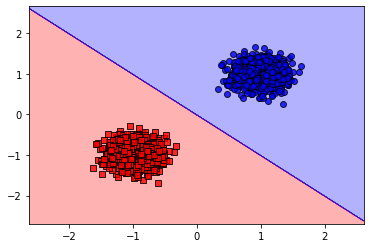

In [338]:
ada_gd = AdalineGD(eta=1e-5, n_iter=50)
ada_gd.fit(dataset_std[:,1:], dataset_std[:,0])
plot_decision_regions(dataset_std[:,1:], dataset_std[:,0], ada_gd)

標準化させない場合、多くのエポック数が必要となることがわかる。

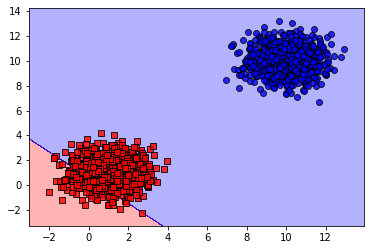

In [346]:
ada_gd = AdalineGD(eta=1e-6, n_iter=50)
ada_gd.fit(dataset[:,1:], dataset[:,0])
plot_decision_regions(dataset[:,1:], dataset[:,0], ada_gd)

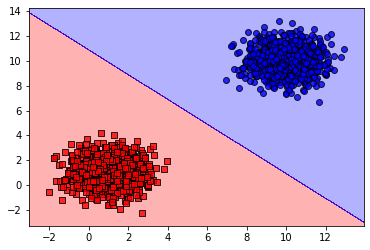

In [347]:
ada_gd = AdalineGD(eta=1e-6, n_iter=5000)
ada_gd.fit(dataset[:,1:], dataset[:,0])
plot_decision_regions(dataset[:,1:], dataset[:,0], ada_gd)

## ロジスティック回帰